In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import scipy.optimize
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from colorspacious import cspace_convert
import colorspacious
import color_tool

In [7]:
mpl.rcParams["figure.dpi"] = 144
plt.style.use('dark_background')

In [8]:
def ciecamify(color):
    if isinstance(color, str):
        color = matplotlib.colors.to_rgb(color)
    if len(color) in (3, 4):
        if max(*color) > 1:
            raise ValueError("Colors should be in RGB [0,1]: %s" % color)
        #print("RGB color %s" % (color,))
        color = cspace_convert(color, "sRGB1", "CIECAM02")
        #print("Converted to %s" % (color,))
        #print("And back via JCh to %s"
        #      % (cspace_convert((color.J, color.C, color.h),
        #                        "JCh",
        #                        "sRGB1"),))
        #print("And back via JCH to %s"
        #      % (cspace_convert((color.J, color.C, color.H),
        #                        "JCH",
        #                        "sRGB1"),))
    if not isinstance(color, colorspacious.JChQMsH):
        raise ValueError("Don't know how to interpret color %s" % color)

    return color

ciecamify("green")

JChQMsH(J=34.25652321238808, C=68.98840589994406, h=136.7281570692301, Q=72.39897409328451, M=49.87336534331974, s=82.99809627886997, H=170.80726815757455)

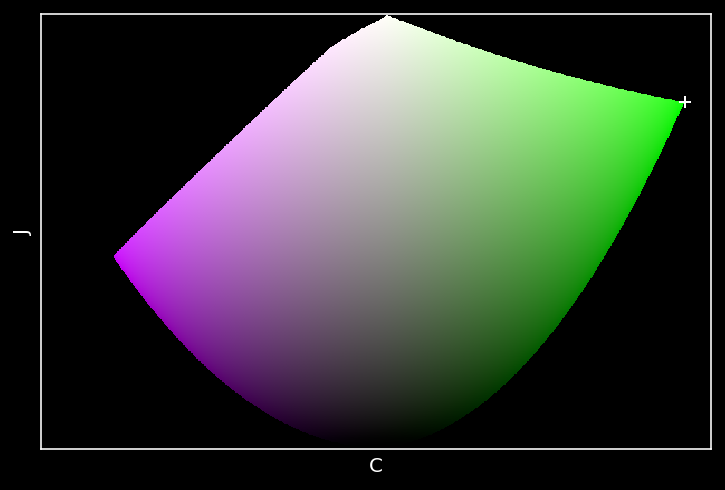

In [10]:
def plot_hue(axes,color,
             hue_parameter='h',
             chroma_parameter="C",
             intensity_parameter="J",
             pixel_size=600):
    color = ciecamify(color)
    fixed = hue_parameter
    fixed_value = getattr(color,fixed)
    x_value = getattr(color, chroma_parameter)
    y_value = getattr(color, intensity_parameter)
    x_max = color_tool.limit(chroma_parameter)
    y_max = color_tool.limit(intensity_parameter)
    space = hue_parameter+chroma_parameter+intensity_parameter
    v = np.zeros((pixel_size, pixel_size+1, 3))
    h = v.shape[0]//2
    v[:h, :, 0] = ((fixed_value + color_tool.limit(fixed)/2)
                   % color_tool.limit(fixed))
    v[h:, :, 0] = fixed_value
    v[:h, :, 0] = ((fixed_value + color_tool.limit(fixed)/2)
                   % color_tool.limit(fixed))
    v[:, :, 1] = np.abs(
            np.linspace(-x_max, x_max, v.shape[0]))[:, None]
    v[:, :, 2] = np.linspace(0, y_max, v.shape[1])[None, :]
    
    srgba = color_tool.add_alpha(
                color_tool.mask_image(
                        cspace_convert(v, space, "sRGB1"),
                        limit=1))
    axes.imshow(srgba.transpose((1, 0, 2)),
                extent=(-x_max, x_max,
                        0, y_max),
                origin="lower")
    axes.plot(x_value,
              y_value,
              "+",
              color="white")
    axes.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False)
    axes.tick_params(
            axis='y',
            which='both',
            left=False,
            right=False,
            labelleft=False)
    axes.set_xlabel(chroma_parameter)
    axes.set_ylabel(intensity_parameter)
    axes.set_aspect('auto')


plot_hue(plt.gca(), (0,1,0))

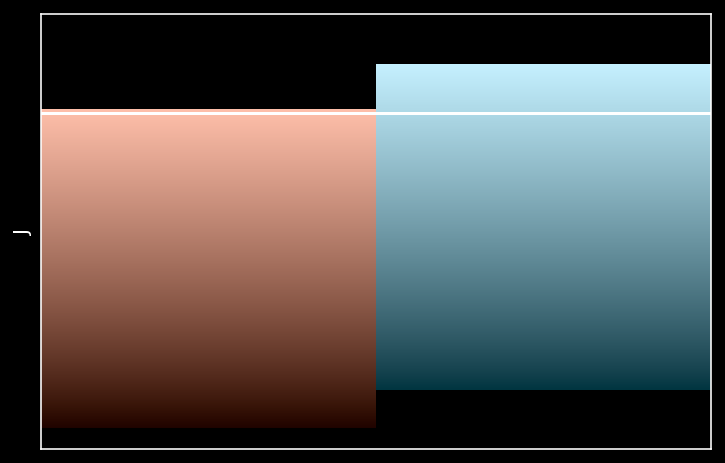

In [38]:
def strip(color,
          hue_parameter='h',
          vary_parameter='C',
          fixed_parameter="J",
          double=False,
          pixel_size=600):
    color = ciecamify(color)
    v_max = color_tool.limit(vary_parameter)
    space = hue_parameter+vary_parameter+fixed_parameter
    v = np.zeros((pixel_size,3))
    h = getattr(color,hue_parameter)
    v[:,2] = getattr(color,fixed_parameter)
    if double:
        v[:pixel_size//2,0] = ((h+color_tool.limit(hue_parameter)/2) 
                               % color_tool.limit(hue_parameter))
        v[pixel_size//2:,0] = h
        v_min = -v_max
    else:
        v[:,0] = h
        v_min = 0
    v[:,1] = np.linspace(v_min,v_max,pixel_size)
    srgba = color_tool.add_alpha(
                color_tool.mask_image(
                        cspace_convert(v, space, "sRGB1"),
                        limit=1))
    return srgba, (v_min, v_max), getattr(color, vary_parameter)

def plot_strip_intensity(axes, color,
                         n=1,
                         hue_parameter='h',
                         chroma_parameter="C",
                         intensity_parameter="J",
                         pixel_size=600):
    color = ciecamify(color)
    d = color._asdict()
    d[hue_parameter] = ((getattr(color,hue_parameter)+color_tool.limit(hue_parameter)/2) 
                        % color_tool.limit(hue_parameter))
    complementary_color = colorspacious.JChQMsH(**d)
    v = np.zeros((2*n,pixel_size,4))
    for i in range(n):
        d = color._asdict()
        d[chroma_parameter] = getattr(color,chroma_parameter)*(n-i)/n
        c = colorspacious.JChQMsH(**d)
        v[-1-i,:,:], (v_min, v_max), v_v = strip(c, 
                     hue_parameter=hue_parameter, 
                     vary_parameter=intensity_parameter,
                     fixed_parameter=chroma_parameter,
                     double=False,
                     pixel_size=pixel_size)
        d = complementary_color._asdict()
        d[chroma_parameter] = getattr(color,chroma_parameter)*(n-i)/n
        c = colorspacious.JChQMsH(**d)
        v[i,:,:], (v_min, v_max), v_v = strip(c, 
                     hue_parameter=hue_parameter, 
                     vary_parameter=intensity_parameter,
                     fixed_parameter=chroma_parameter,
                     double=False,
                     pixel_size=pixel_size)
    image = axes.imshow(v.transpose((1, 0, 2)),
                        extent=(0, 1,
                                v_min, v_max),
                        origin="lower")
    line = axes.axhline(v_v,
                        color="white")
    axes.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False)
    axes.tick_params(
            axis='y',
            which='both',
            left=False,
            right=False,
            labelleft=False)
    axes.set_ylabel(intensity_parameter)
    axes.set_aspect('auto')
    
plot_strip_intensity(plt.gca(), "lightblue")

In [39]:
c = ciecamify("green")

In [40]:
c[:]

(34.25652321238808,
 68.98840589994406,
 136.7281570692301,
 72.39897409328451,
 49.87336534331974,
 82.99809627886997,
 170.80726815757455)

In [41]:
c._asdict()

OrderedDict([('J', 34.25652321238808),
             ('C', 68.98840589994406),
             ('h', 136.7281570692301),
             ('Q', 72.39897409328451),
             ('M', 49.87336534331974),
             ('s', 82.99809627886997),
             ('H', 170.80726815757455)])

red
green
blue
purple
yellow
orange
pink


<Figure size 864x576 with 0 Axes>

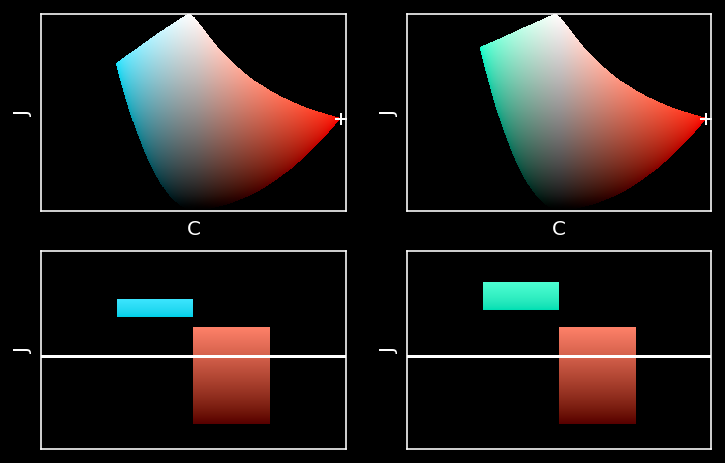

<Figure size 864x576 with 0 Axes>

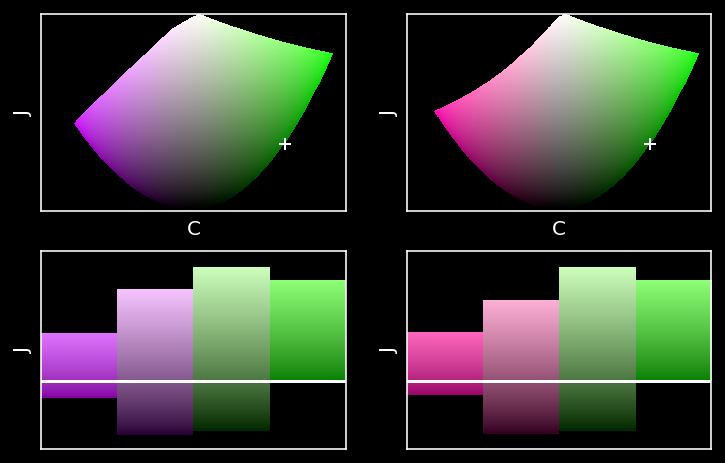

<Figure size 864x576 with 0 Axes>

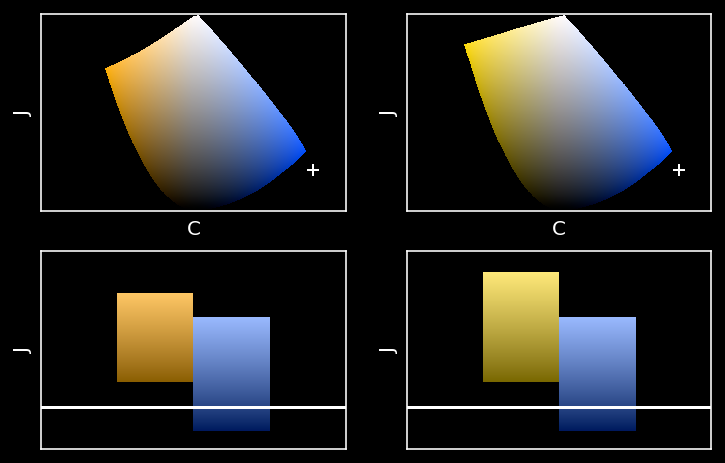

<Figure size 864x576 with 0 Axes>

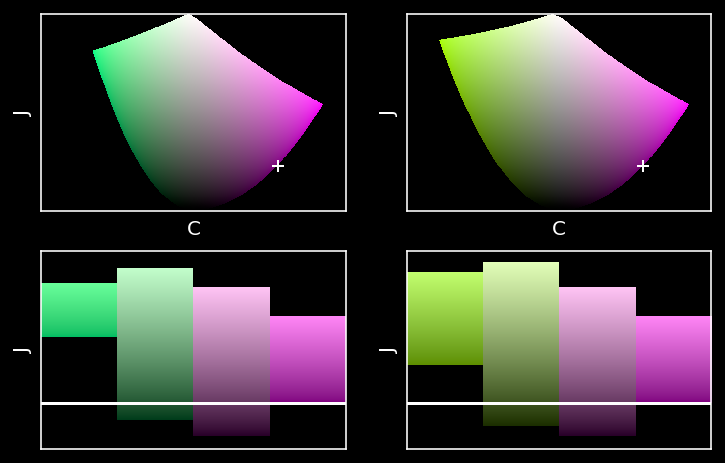

<Figure size 864x576 with 0 Axes>

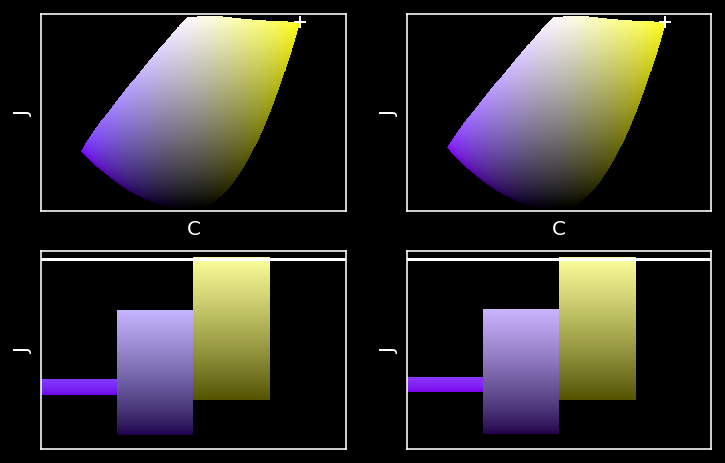

<Figure size 864x576 with 0 Axes>

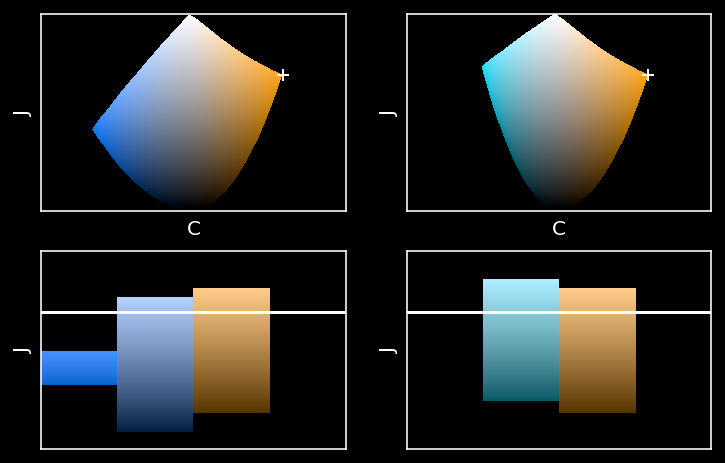

<Figure size 864x576 with 0 Axes>

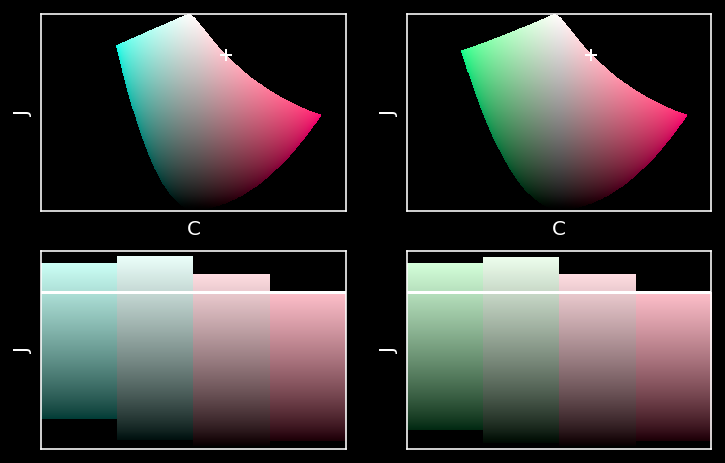

In [45]:
def complementary_comparisons(colors,
                             chroma_parameter="C",
                             intensity_parameter="J",
                             pixel_size=600):
    
    #fig, ax_list = plt.subplots(len(colors),2)
    #for color, (ax_h, ax_H) in zip(colors, ax_list):
    for color_name in colors:
        plt.figure()
        fig, ((ax_h, ax_H),(bar_h, bar_H)) = plt.subplots(2,2)
        print(color_name)
        color = ciecamify(color_name)

        plot_hue(ax_h, color, 
                 hue_parameter="h",
                 chroma_parameter=chroma_parameter,
                 intensity_parameter=intensity_parameter,
                 pixel_size=pixel_size)
        plot_hue(ax_H, color, 
                 hue_parameter="H",
                 chroma_parameter=chroma_parameter,
                 intensity_parameter=intensity_parameter,
                 pixel_size=pixel_size)
        plot_strip_intensity(bar_h, color, n=2,
                 hue_parameter="h",
                 chroma_parameter=chroma_parameter,
                 intensity_parameter=intensity_parameter,
                 pixel_size=pixel_size)
        plot_strip_intensity(bar_H, color, n=2,
                 hue_parameter="H",
                 chroma_parameter=chroma_parameter,
                 intensity_parameter=intensity_parameter,
                 pixel_size=pixel_size)
        plt.savefig("h-vs-H-%s.png" % color_name, dpi=144)
complementary_comparisons(["red","green","blue","purple","yellow", "orange","pink"])